## Test Extracting Images

In [18]:
# USE ACCOUNT: robmarty3@gmail.com
import ee
ee.Authenticate()
ee.Initialize()

Enter verification code:  4/1AX4XfWgin0dkw8RQ2vD1F0-npzTn52gZheS7VFNFu4wKg8U9g7DpNHjAgcQ



Successfully saved authorization token.


In [239]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import config as cf
import ee_utils as utils
from geetools import ui, cloud_mask

cloud_mask_landsatSR = cloud_mask.landsatSR()
cloud_mask_sentinel2 = cloud_mask.sentinel2()

In [240]:
def normalized_diff(values1, values2):
    '''
    Normalized Difference Value

    Input:  values1, values2 (must be same dimensions)

    Output: np array
    '''

    return (values2 - values1)/(values2 + values1)

In [241]:
SURVEY_NAME = 'DHS'
satellite = 's2'
kernel_size = 167
year = 2019

if satellite == 's2':
    kernel_size = 250
elif satellite == 'l8':
    kernel_size = 167

In [242]:
survey_df = pd.read_csv(os.path.join(cf.DROPBOX_DIRECTORY, 'Data', SURVEY_NAME, 'FinalData', 'Individual Datasets', 'data_for_cnn.csv'))

In [243]:
survey_df = survey_df.iloc[[2]]
survey_df

,uid,GID_2,year,ntl_group,longitude,latitude,tfrecord_name,use_for_cnn
2,GY200900000289,GUY.3.2_1,2009,2,-58.130274,6.821071,forcnn_GY_3_1_all.tfrecord,yes


In [244]:
# Setup --------------------------------------------------------------------
# Survey to FeatureCollection  
survey_fc = utils.survey_to_fc(survey_df)

# Define kernel for neighborhood array
list = ee.List.repeat(1, kernel_size)
lists = ee.List.repeat(list, kernel_size)
kernel = ee.Kernel.fixed(kernel_size, kernel_size, lists)

# Define scale
if satellite in ['l7', 'l8']:
    SCALE = 30
elif satellite in ['s2']: 
    SCALE = 10

In [245]:
# l8 ----------------------------------------------------------------
if satellite == "l8":

    # Bands
    # FOR COLLECTION 2
    #b_b = 'SR_B2'
    #g_b = 'SR_B3' 
    #r_b = 'SR_B4' 
    #nir_b = 'SR_B5'
    #other_bs = ['SR_B6', 'SR_B7', 'ST_B10']

    # FOR COLLECTION 1
    b_b = 'B2'
    g_b = 'B3' 
    r_b = 'B4' 
    nir_b = 'B5'
    other_bs = ['B6', 'B7', 'B10']

    BANDS = other_bs.copy()
    BANDS.append(b_b)
    BANDS.append(g_b)
    BANDS.append(r_b)
    BANDS.append(nir_b)

    # Year
    # landsat 8 starts in April 2013; if year is less than
    # 2014, use 2014 as year (to ensure have year before and after)
    if year < 2014:
        year_use = 2014
    else:
        year_use = year

    year_plus = year_use + 1
    year_minus = year_use - 1

    year_minus_str = str(year_minus) + '-01-01'
    year_plus_str = str(year_plus) + '-12-31'

    image = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR')\
        .filterDate(year_minus_str, year_plus_str)\
        .map(cloud_mask_landsatSR)\
        .median()

In [246]:
if satellite == "s2":

    # Bands
    b_b = 'B2'
    g_b = 'B3' 
    r_b = 'B4' 
    nir_b = 'B8'
    other_bs = ['B5', 'B6', 'B7', 'B8A', 'B11', 'B12', 'AOT']

    BANDS = other_bs.copy()
    BANDS.append(b_b)
    BANDS.append(g_b)
    BANDS.append(r_b)
    BANDS.append(nir_b)

    # Year
    # sentinel starts in March 2017; juse use 2018
    year_use = 2018

    year_plus = year_use + 1
    year_minus = year_use - 1

    year_minus_str = str(year_minus) + '-01-01'
    year_plus_str = str(year_plus) + '-12-31'

    # Number of bands changes in sentinel, so need to select here before aggregate
    # https://gis.stackexchange.com/questions/374010/gee-tile-error-expected-a-homogeneous-image-collection-but-an-image-with-incom
    image = ee.ImageCollection('COPERNICUS/S2_SR')\
        .filterDate(year_minus_str, year_plus_str)\
        .map(cloud_mask_sentinel2)\
        .select(BANDS)\
        .median() # \
        #.multiply(0.0001)


In [277]:
# Select Bands
image = image.select(BANDS)

# Image to neighborhood array
arrays = image.neighborhoodToArray(kernel)

# Extract values from GEE   
values_ee = arrays.sample(
  region = survey_fc, 
  scale = SCALE,
  tileScale = 8
)

dict_ee = values_ee.getInfo()

# Convert values to numpy array
n_rows = survey_df.shape[0]
daytime_f = dict_ee['features']

AttributeError: 'numpy.ndarray' object has no attribute 'select'

In [ ]:
i = 0
d_f_i = daytime_f[i]['properties']

In [281]:
brgb_l = [np.array(d_f_i[r_b]), np.array(d_f_i[g_b]), np.array(d_f_i[b_b])]
brgb_np = np.stack(brgb_l, axis=-1)

In [282]:
bndvi_np = normalized_diff(np.array(d_f_i[nir_b]), np.array(d_f_i[r_b]))
#bndvi_np = np.expand_dims(bndvi_np, axis=2) # original (224, 224), change to (224,224,1) -> so can stack

In [283]:
# https://gis.stackexchange.com/questions/341809/merging-sentinel-2-rgb-bands-with-rasterio
import rasterio
import numpy as np
from rasterio import plot
from rasterio.plot import show
from skimage import exposure

from matplotlib import pyplot as plt


In [289]:
# Rescale the image (divide by 10000 to convert to [0:1] reflectance
image = brgb_np

image = image.astype(np.uint16)
brgb_np_tf = tf.io.encode_png(image, compression = 9)
#image = tf.io.decode_png(brgb_np_tf, dtype=tf.dtypes.uint16)
image = tf.io.decode_png(brgb_np_tf, dtype=tf.dtypes.uint16)
image = image / 100000


p2, p98 = np.percentile(image, (2,98))
image = exposure.rescale_intensity(image, in_range=(p2, p98)) # / 100000

# Plot the RGB image
#show(image.transpose(2,0,1), transform=img.transform)
plt.imshow(image)
plt.show()

AttributeError: 'DType' object has no attribute 'type'

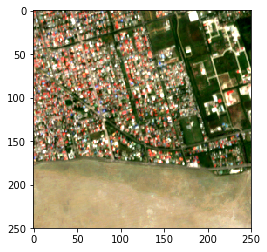

In [286]:
# Rescale the image (divide by 10000 to convert to [0:1] reflectance
image = brgb_np

image = image.astype(np.uint16)
image = image / 100000


p2, p98 = np.percentile(image, (2,98))
image = exposure.rescale_intensity(image, in_range=(p2, p98)) # / 100000

# Plot the RGB image
#show(image.transpose(2,0,1), transform=img.transform)
plt.imshow(image)
plt.show()

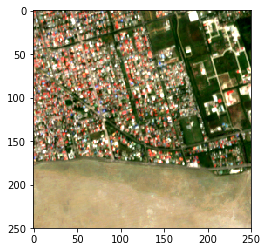

In [262]:
plt.imshow(image, interpolation='none')
plt.show()